# ELM for Peaks Classificaiton

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import scipy.io
import pandas as pd

home_dir = pathlib.Path("/c/Users/thsiao3/Documents/emory_class/MATH789/hw4/")
os.chdir(home_dir)

import ELM

In [3]:
data_dir = home_dir / "PeaksClassification.mat"
results_class = pd.read_csv(home_dir / "results/ELMClass_results_BFGS.csv")

Y = scipy.io.loadmat(data_dir)
Ytrain = Y['Ytrain']
Ytest = Y['Ytest']
Ctrain = Y['Ctrain']
Ctest = Y['Ctest']

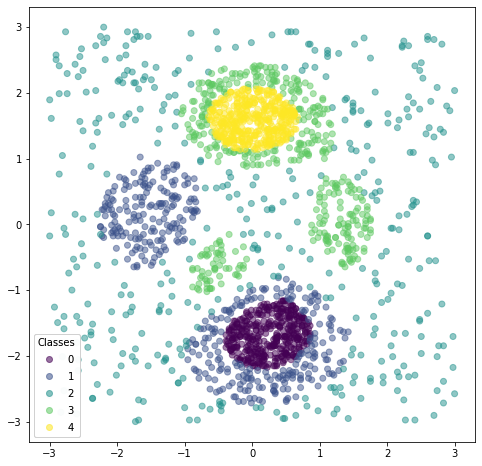

In [4]:
colors = np.argmax(Ctrain, 0)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
scatter = ax.scatter(Ytrain[0], Ytrain[1], c=colors, alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

To solve the cross entropy optimization for this dataset, I originally tried the steepest descent with Armijo linesearch I wrote for last weeks homework, but my solution was not converging well. The loss began to decrease very slowly, even at the thousands of iterations. Newton-CG and BFGS also did not give a good solution. However, L-BFGS-S gave a substantially better solution than the other minimizers and is what I use for this problem. 

<Figure size 1440x720 with 0 Axes>

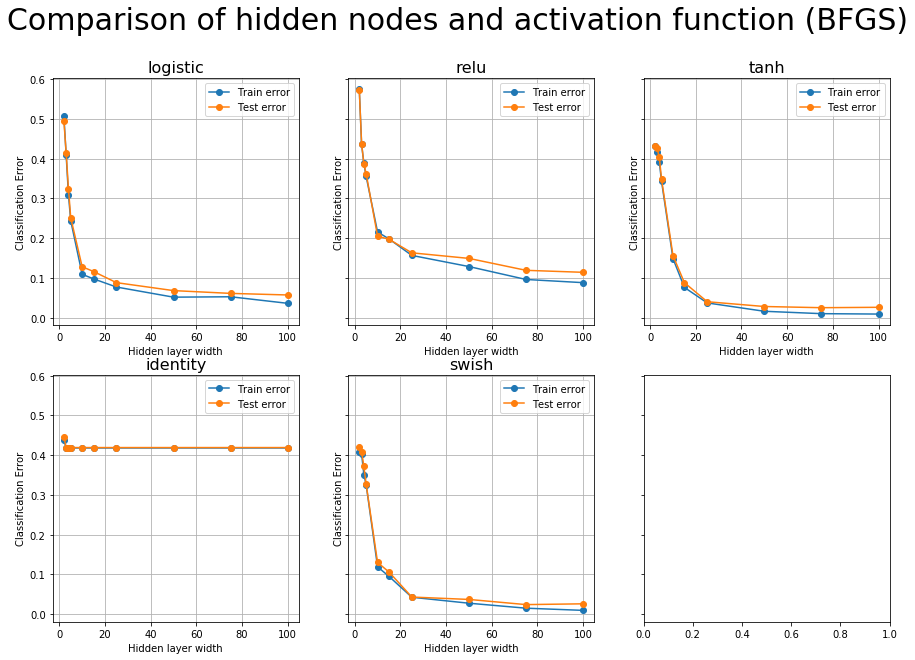

In [5]:
n = len(results_class.activation.unique())
f = plt.figure(figsize=(20, 10))
f, axs = plt.subplots(2, round(n/2)+1, figsize=(15,10), sharey=True)
f.suptitle('Comparison of hidden nodes and activation function (BFGS)', fontsize=30)
for k in range(n):
    fun = results_class.activation.unique()[k]
    temp = results_class[results_class.activation == fun]
    ax = axs.ravel()[k]
    ax.set_title("{}".format(fun), fontsize=16)
    ax.plot(temp['m'], temp['train_error'], marker='o', label='Train error')
    ax.plot(temp['m'], temp['test_error'], marker='o', label='Test error')
    ax.legend()
    ax.grid()
    ax.set_ylabel('Classification Error')
    ax.set_xlabel('Hidden layer width')

I'm not sure why my implementation of the relu function does not end up overfitting. I'm also confused as to why the tanh 
function does not overfit at high 'm' like the logistic or swish functions. The test error in every scenario follows the training error very closely. In the regression, training error goes to 0 quickly while the hidden nodes increase. The test error decreases, and then begins to increase after a threshold of the hidden node number. The train and test errors ended up having pretty different trajectories. But for classification, the test error never increases for the logistic activation, even at high 'm' indicating overfitting is not occurring. And across the board the test and train increase and decrease together.

I would have thought from the ELM theory that as you increase the number of hidden nodes, you'd be able to fit the training data perfectly. But some of these activation functions actually get much worse, even in the training error not just the test error as you increase the hidden node number. I'll have to dig deeper into the implementation of these activation functions as well as exploring the L-BFGS-B solver. 

In [6]:
results_class[results_class['test_error'] == results_class['test_error'].min()]

,m,activation,train_error,test_error
44,75,swish,0.015,0.024


In [43]:
model_class = ELM.ELM(Ytrain, Ctrain, m=100, sigma=np.tanh)
model_class.fit(type="class", method="Newton-CG", options={'maxiter':100})

In [44]:
# Model Preds grid
x = np.arange(-3,3.1,.05)
y = np.arange(-3,3.1,.05)
Grid = np.array([np.array([a, b]) for a in x for b in y]).T
preds = model_class.predict(Grid)

In [45]:
print("Training error: {}".format(np.mean(model_class.predict(Ytrain) == np.argmax(Ctrain,0))))
print("Testing error: {}".format(np.mean(model_class.predict(Ytest) == np.argmax(Ctest,0))))

Training error: 0.999
Testing error: 0.977


[]

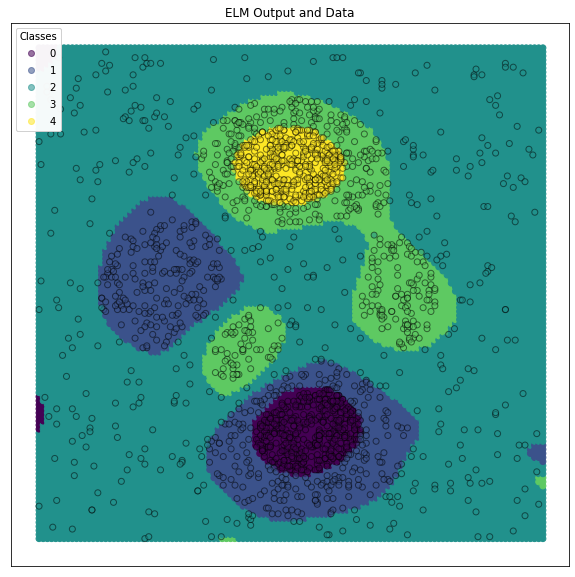

In [46]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(Grid[0], Grid[1], c=preds)
ax.set_title("ELM Output and Data")
scatter = ax.scatter(Ytrain[0], Ytrain[1], c=colors, alpha=0.5, edgecolors='black')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
ax.set_xticks([])
ax.set_yticks([])